In [1]:
import torch
import numpy as np
from celluloid import Camera
from IPython.display import HTML
from matplotlib import pyplot as plt

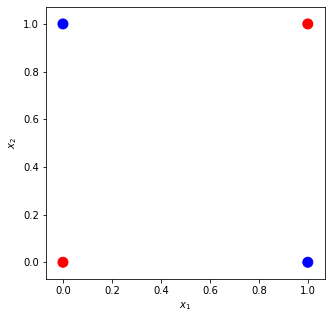

In [2]:
x = np.array([(x1, x2) for x1 in [0, 1] for x2 in [0, 1]])
y = x[:, 0] ^ x[:, 1]

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax.scatter(x[:, 0], x[:, 1], c=np.array(['red','blue'])[y], s=100)
plt.show()

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
camera = Camera(fig)

ax.set_aspect('equal')
ax.set_xlim(-1,2)
ax.set_ylim(-1,2)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

for i in range(20):
    a = np.random.uniform(-1, +1)
    b = np.random.uniform(-1, +1)
    x_ = np.linspace(-1, 2, 100)
    y_ = a*x_ + b
    
    ax.scatter(x[:, 0], x[:, 1], c=np.array(['red','blue'])[y], s=100)
    
    ax.plot(x_, y_, '--', c='black')
    ax.fill_between(x_, -1, y_, color='red', alpha=.2)
    ax.fill_between(x_, y_, 2, color='blue', alpha=.2)
    
    camera.snap()
    
plt.close()
    
animation = camera.animate(interval=400)
HTML(animation.to_html5_video())

# Let's apply the following linear transformation:

## $h_1 = x_1 + x_2$

## $h_2 = x_1 + x_2 - 1$

In [5]:
def draw_XOR_transformation(x, h):
    fig, ax = plt.subplots(figsize=(5, 5))
    camera = Camera(fig)
    ax.set_aspect('equal')
    ax.set_xlabel('$h_1$')
    ax.set_ylabel('$h_2$')

    for a in np.concatenate([np.linspace(0, 1, 20), np.linspace(1, 0, 20)]):
        ax.scatter(
            (1-a)*x[:, 0] + a*h[:, 0],
            (1-a)*x[:, 1] + a*h[:, 1],
            c=np.array(['red','blue'])[y],
            s = 100
        )
        camera.snap()

    plt.close()

    animation = camera.animate(interval=100)
    return HTML(animation.to_html5_video())

In [6]:
h = np.zeros_like(x)
h[:, 0] = x[:, 0] + x[:, 1]
h[:, 1] = x[:, 0] + x[:, 1] - 1
draw_XOR_transformation(x, h)

# Now let's *slightly* modify the transformation:

## $h = \left\{\begin{array}[cc]
    ~h & \textrm{if } h > 0 \\
    0 & \textrm{if } h \leq 0
\end{array}\right.$

In [7]:
h = np.where(h <= 0, 0, h)
draw_XOR_transformation(x, h)

# Note that now we can split the two clases using a line:

## $y = 0.5x - 0.2$

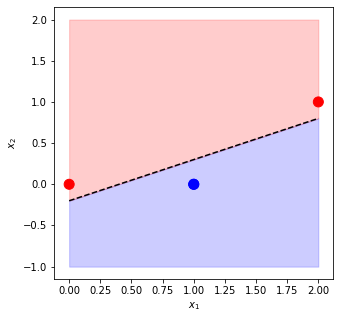

In [8]:
a = .5
b = -.2
x_ = np.linspace(0, 2, 2)
y_ = a*x_ + b

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.scatter(h[:, 0], h[:, 1], c=np.array(['red','blue'])[y], s=100)
ax.plot(x_, y_, '--', c='black')
ax.fill_between(x_, -1, y_, color='blue', alpha=.2)
ax.fill_between(x_, y_, 2, color='red', alpha=.2)
plt.show()

# Another example: circular boundaries

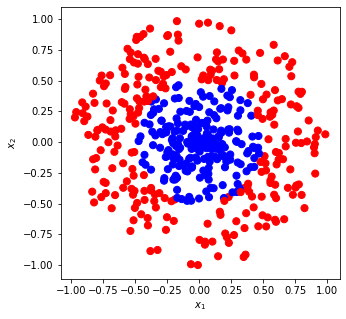

In [9]:
# Sample N points in polar coordinates
N = 500
r = np.random.uniform(0, 1, N)
θ = np.random.uniform(0, 2*np.pi, N)
y = (r < .5).astype(int)

# Convert to cartesian coordinates
x = np.zeros((N, 2))
x[:, 0], x[:, 1] = r*np.cos(θ), r*np.sin(θ)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.scatter(x[:, 0], x[:, 1], c=np.array(['red','blue'])[y], s=50)
plt.show()

# It's not linearly separable, but with the appropriate transformation...

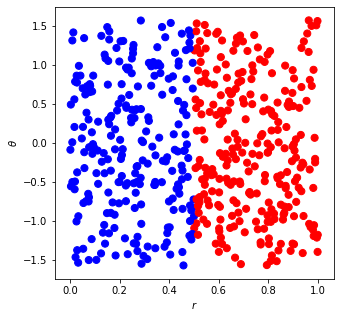

In [10]:
# Convert back to polar
N = 500
r = np.sqrt(x[:, 0]**2 + x[:, 1]**2)
θ = np.arctan(x[:, 1] / x[:, 0])

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('$r$')
ax.set_ylabel('$θ$')
ax.scatter(r, θ, c=np.array(['red','blue'])[y], s=50)
plt.show()

# Perfect!
## The problem is that the this specific transformation, involving $\sqrt{}$, $x^2$, $\arctan$, is not easy to learn in a general way

## Fortunately, neural networks are "universal approximators"

![](universal-approx.png)

In [ ]:
from torch.nn import Sequential, Linear, LeakyReLU, Sigmoid, BCELoss

n = 10 # hidden neurons
classifier = Sequential(
    Linear(2, n),
    LeakyReLU(),
    #Linear(n, n),
    #LeakyReLU(),
    Linear(n, 2),
    LeakyReLU(),
    Linear(2, 1),
    Sigmoid()
)

# Sample N points in polar coordinates
N = 10**3
r = torch.rand(N)
θ = 2*np.pi*torch.rand(N)
y = (r < .5).float().unsqueeze(1)
# Convert to cartesian coordinates
x = torch.zeros((N, 2))
x[:, 0], x[:, 1] = r*np.cos(θ), r*np.sin(θ)

# Use binary cross entropy loss
loss_fn = BCELoss()

# Use Adam optimizer
opt = torch.optim.Adam(classifier.parameters())

# Pyplot stuff
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
camera = Camera(fig)

n_epochs = 10
batch_size = 20
# Run for many epochs
for epoch_i in range(n_epochs):
    # Iterate over all examples (grouped in batches) in each epoch
    for batch_i in range(N//batch_size):
        
        # Get indices of batch examples
        idx = np.arange(batch_i*batch_size, (batch_i+1)*batch_size)
        
        # Get predictions (probabilities) from classifier
        y_prob = classifier(x[idx])
        
        # Compute loss
        loss = loss_fn(y_prob, y[idx])
        
        # Apply gradient descent step
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # Pyplot stuff
        if batch_i % 10 == 0:
            h = classifier[:-2](x).detach().numpy()
            ax.scatter(
                h[:, 0], h[:, 1],
                c=np.array(['red','blue'])[y.int().squeeze().detach().numpy()]
            )
            camera.snap()
    
    # Print overall loss and accuracy
    y_pred = classifier(x)
    acc = 100*(y_pred.round() == y).float().mean()
    print(f'Epoch {epoch_i} Loss = {loss:.3f} Acc={acc:.1f}%')
    
plt.close()

animation = camera.animate(interval=100)
HTML(animation.to_html5_video())

Epoch 0 Loss = 0.704 Acc=49.1%
Epoch 1 Loss = 0.692 Acc=62.6%
Epoch 2 Loss = 0.680 Acc=71.5%
Epoch 3 Loss = 0.667 Acc=70.4%
Epoch 4 Loss = 0.655 Acc=66.3%
Epoch 5 Loss = 0.644 Acc=65.4%
Epoch 6 Loss = 0.636 Acc=65.6%
Epoch 7 Loss = 0.628 Acc=65.7%
Epoch 8 Loss = 0.620 Acc=67.0%
Epoch 9 Loss = 0.613 Acc=67.5%


## Activations as "space folding"
![](space-folding.png)